# **Web Scrapering Tool**

- Goal: Scrape book details (title, price, availability, rating, etc.) and store them in Firestore.
- Tools Used: Python, Requests, BeautifulSoup, Pandas, Firebase Firestore
- Output: Books stored in Firestore + CSV file

# Step 1: Install Required Libraries
To work with web scraping and Firestore, we need:
- `requests`: for making HTTP requests
- `BeautifulSoup`: for parsing HTML
- `pandas`: for handling scraped data
- `firebase_admin`: for Firestore integration


In [ ]:
!pip install requests beautifulsoup4 pandas firebase-admin


# Step 2: Import Required Libraries
This step loads all the necessary Python packages.


In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import re
import firebase_admin
from firebase_admin import credentials, firestore
import psutil
import requests
from concurrent.futures import ThreadPoolExecutor


# Step 3: Set Up Firebase Firestore

## Step 3.1: Create a Firebase Project
1. Go to **[Firebase Console](https://console.firebase.google.com/)**  
2. Click **"Add project"** and enter a project name.  
3. Click **"Continue"** and follow the setup steps.  
4. Click **"Create"** and wait for Firebase to initialize the project.  

---

## Step 3.2: Enable Firestore Database
1. In the Firebase Console, go to **"Firestore Database"** from the left menu.  
2. Click **"Create Database"** → Choose **"Start in test mode"** (for development).  
3. Select your **Cloud Firestore location** (nearest region).  
4. Click **"Enable"** and wait for Firestore setup to complete.  

---

## Step 3.3: Get Firebase Credentials
1. In Firebase Console, go to **"Project Settings"** (gear icon in the top left).  
2. Click the **"Service accounts"** tab.  
3. Click **"Generate new private key"** → A JSON file will download.  
4. **Upload this JSON file** to Colab using the following code:

```python
from google.colab import files
uploaded = files.upload()
```

---

## Step 3.4: Connect Firestore to Colab
**Load Firebase Credentials & Initialize Firestore:**

```python
import firebase_admin
from firebase_admin import credentials, firestore

# Replace 'your-file.json' with the uploaded file name
service_account_path = "/content/your-firebase-key.json"

# Prevent multiple Firebase initializations
if not firebase_admin._apps:
    cred = credentials.Certificate(service_account_path)
    firebase_admin.initialize_app(cred)

# Connect to Firestore
db = firestore.client()
collection_ref = db.collection("books")

print("Firestore connected successfully!")
```




In [ ]:
service_account_path = "/content/serviceAccountKey.json"

if not firebase_admin._apps:
    cred = credentials.Certificate(service_account_path)
    firebase_admin.initialize_app(cred)

db = firestore.client()
collection_ref = db.collection("books")


# Step 4: Define the Target URL & HTTP Session
- The base URL is `http://books.toscrape.com/`
- A session object is created to manage requests.
- The User-Agent header is added to mimic a browser request.


In [ ]:
base_url = "http://books.toscrape.com/"
session = requests.Session()
session.headers.update({
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
})


# Step 5: Scraping and Storing Data in Firestore

## Overview
## In this step, we will:
1. **Scrape book data** from the website.
2. **Extract and clean** price data.
3. **Store the extracted data** into Firestore.
4. **Save the scraped data** to a CSV file.
5. **Validate the extracted data** for accuracy.

---

## Scraping and Extracting Book Data
We use BeautifulSoup to extract:
- **Title**
- **Price (cleaned)**
- **Availability**
- **Rating**
- **Image URL**
- **Product Page URL**


## The output Image is structure of storing of the data in firestore

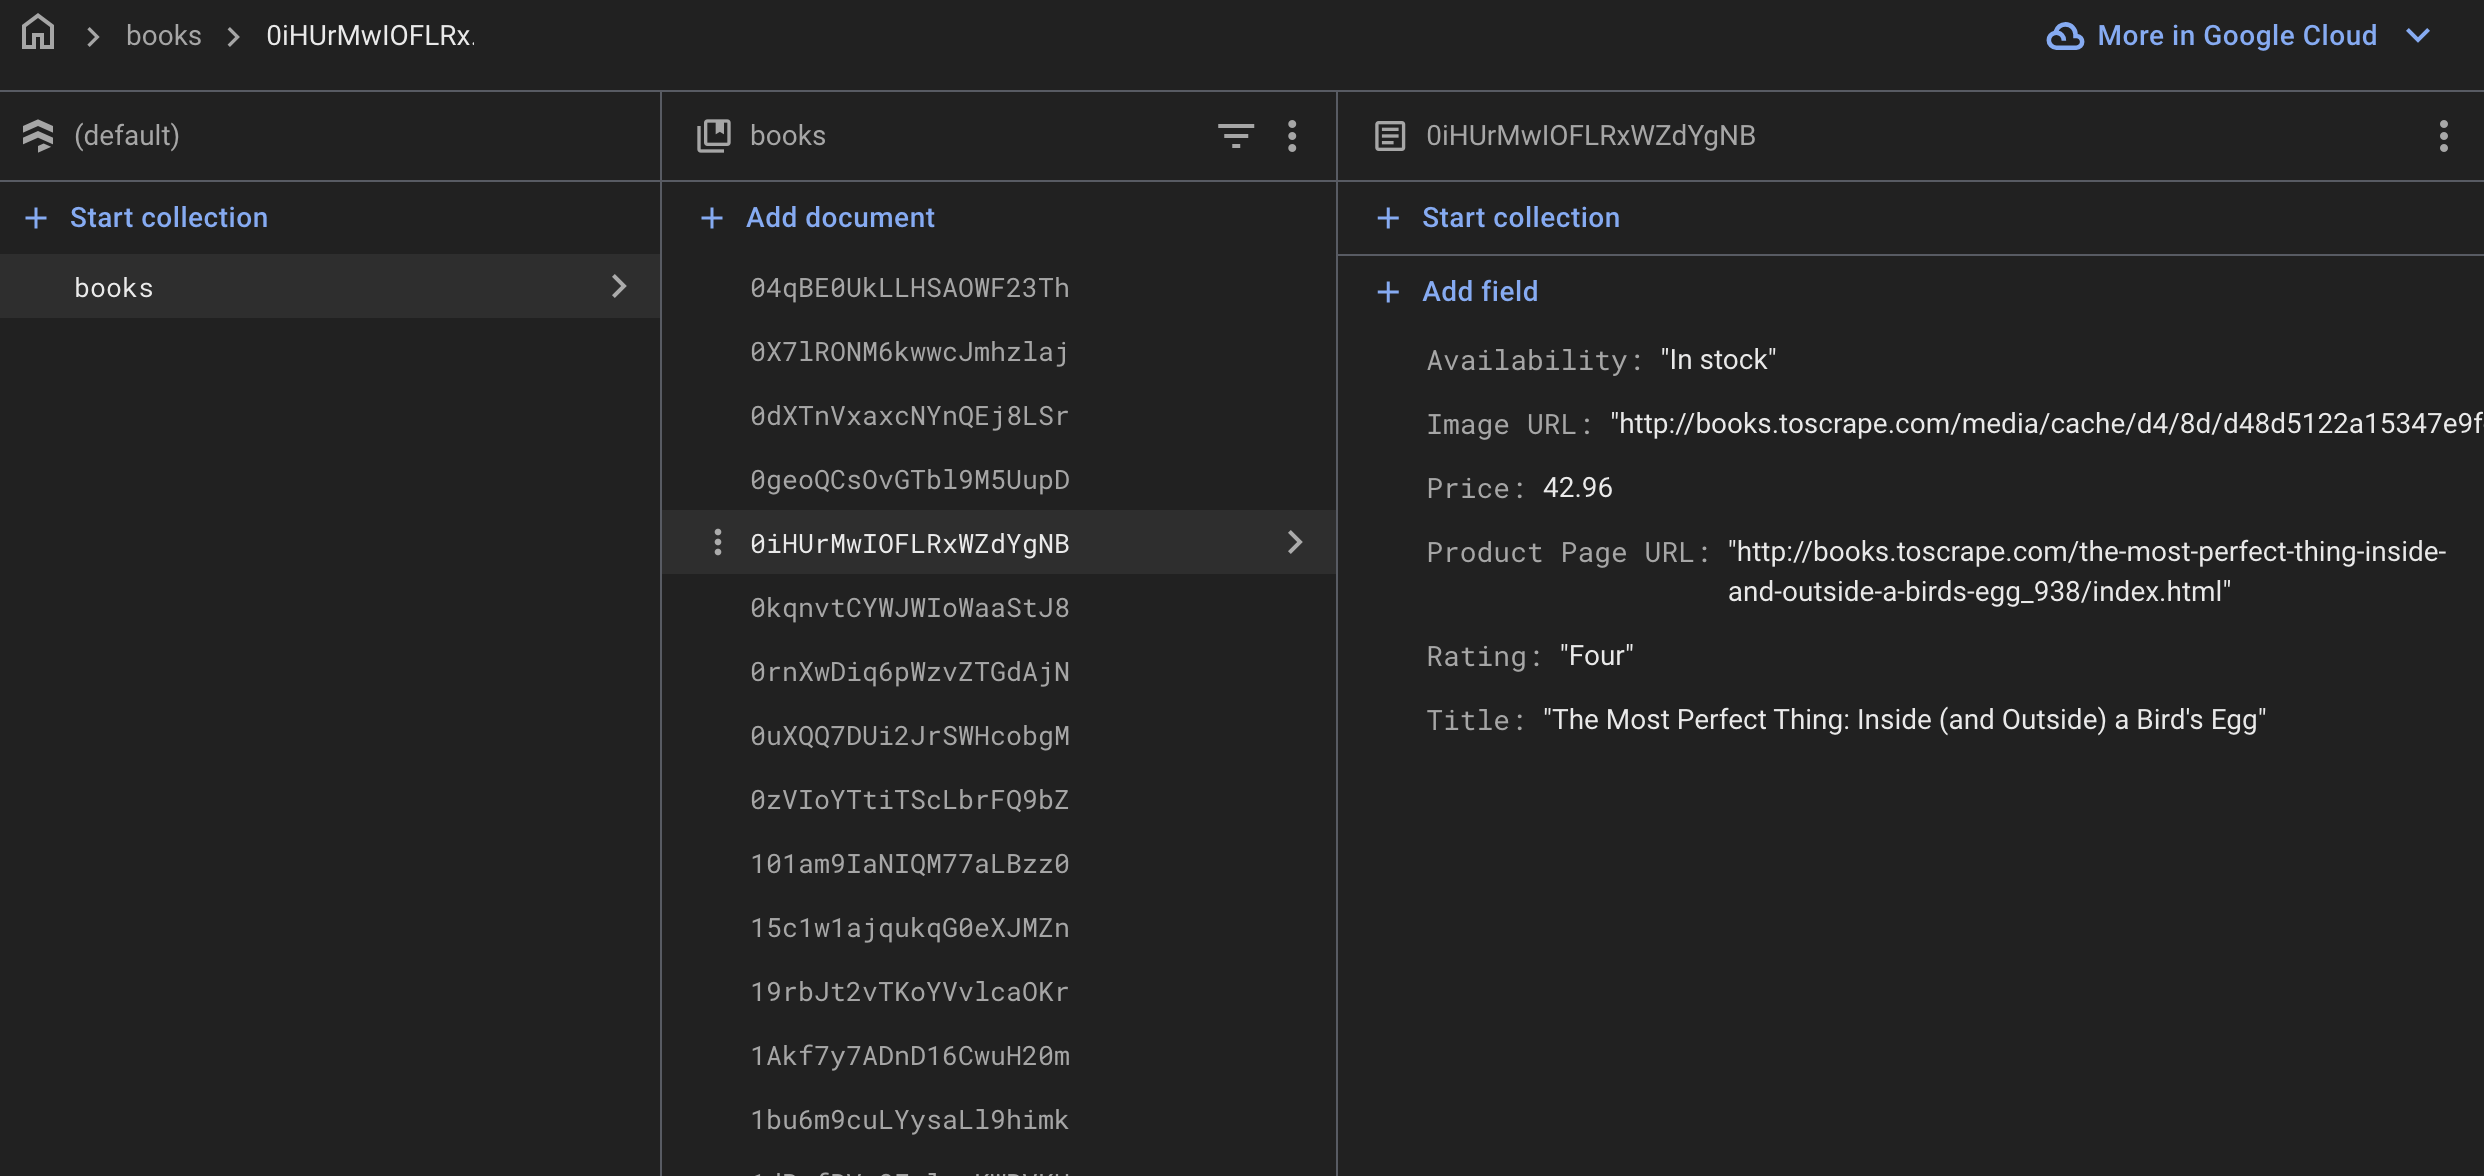



In [ ]:
start_time = time.time()
book_list = []
page = 1

while True:
    url = f"{base_url}catalogue/page-{page}.html"
    print(f"Fetching page {page}...")

    try:
        response = session.get(url, timeout=10)
        response.raise_for_status()
    except requests.exceptions.RequestException as err:
        print(f"Error occurred: {err}")
        break

    if response.status_code != 200:
        print("No more pages to scrape.")
        break

    soup = BeautifulSoup(response.text, "html.parser")
    books = soup.find_all("article", class_="product_pod")

    if not books:
        print("No books found on this page. Stopping.")
        break

    for book in books:
        try:
            title = book.h3.a["title"].strip()

            price_text = book.find("p", class_="price_color").text.strip()
            price_cleaned = re.sub(r"[^\d.]", "", price_text)
            price = float(price_cleaned)

            availability = book.find("p", class_="instock availability").text.strip()
            rating = book.p["class"][1] if book.p and "class" in book.p.attrs else "No Rating"
            image_url = base_url + book.find("img")["src"].replace("../", "")
            product_page_url = base_url + book.h3.a["href"].replace("../", "")

            book_data = {
                "Title": title,
                "Price": price,
                "Availability": availability,
                "Rating": rating,
                "Image URL": image_url,
                "Product Page URL": product_page_url,
            }

            book_list.append(book_data)

            collection_ref.add(book_data)
            print(f"Uploaded: {title}")

        except (AttributeError, ValueError, AssertionError) as e:
            print(f"Data extraction error: {e}")
            continue

    next_page = soup.find("li", class_="next")
    if next_page:
        page += 1
    else:
        break

# Step 6: Saving Data to CSV  

The scraped data is stored in a CSV file using Pandas for further analysis. This ensures easy access and structured storage.


In [ ]:


df = pd.DataFrame(book_list)

csv_filename = "books.csv"
df.to_csv(csv_filename, index=False, encoding="utf-8")

print(f"Data successfully saved to {csv_filename}")


# Step 7: Data Testing

Ensure all columns have consistent data types and no missing values. Check for duplicates and validate price ranges to maintain data quality.


In [5]:
df = pd.read_csv("books.csv")

print("First few records:\n", df.head())
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)
duplicates = df.duplicated().sum()
print(f"\nDuplicate Records: {duplicates}")

if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print("\nDuplicates removed.")

print("\nPrice Range Stats:\n", df['Price'].describe())



First few records:
                                    Title  Price Availability Rating  \
0                   A Light in the Attic  51.77     In stock  Three   
1                     Tipping the Velvet  53.74     In stock    One   
2                             Soumission  50.10     In stock    One   
3                          Sharp Objects  47.82     In stock   Four   
4  Sapiens: A Brief History of Humankind  54.23     In stock   Five   

                                           Image URL  \
0  http://books.toscrape.com/media/cache/2c/da/2c...   
1  http://books.toscrape.com/media/cache/26/0c/26...   
2  http://books.toscrape.com/media/cache/3e/ef/3e...   
3  http://books.toscrape.com/media/cache/32/51/32...   
4  http://books.toscrape.com/media/cache/be/a5/be...   

                                    Product Page URL  
0  http://books.toscrape.com/catalogue/catalogue/...  
1  http://books.toscrape.com/catalogue/catalogue/...  
2  http://books.toscrape.com/catalogue/catalogue/..

# Step 8: Measuring Script Efficiency

## Why Measure Efficiency?
To ensure our script runs optimally, we analyze:
- **Execution Time**  (How fast does it run?)
- **Memory Usage**  (How much RAM does it consume?)
- **CPU Utilization**  (How much processing power does it use?)

In [10]:
base_url = "http://books.toscrape.com/"

def task(page):
    """Scrapes book data from a given page and returns extracted details"""
    url = f"{base_url}catalogue/page-{page}.html"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
    except requests.exceptions.RequestException as err:
        print(f"Error fetching page {page}: {err}")
        return []

    soup = BeautifulSoup(response.text, "html.parser")
    books = soup.find_all("article", class_="product_pod")

    if not books:
        print(f"No books found on page {page}. Stopping.")
        return []

    book_list = []
    for book in books:
        try:
            title = book.h3.a["title"].strip()
            price_text = book.find("p", class_="price_color").text.strip()
            price_cleaned = re.sub(r"[^\d.]", "", price_text)  # Keep only numbers and decimal
            price = float(price_cleaned)
            availability = book.find("p", class_="instock availability").text.strip()
            rating = book.p["class"][1] if book.p and "class" in book.p.attrs else "No Rating"
            image_url = base_url + book.find("img")["src"].replace("../", "")
            product_page_url = base_url + book.h3.a["href"].replace("../", "")

            book_data = {
                "Title": title,
                "Price": price,
                "Availability": availability,
                "Rating": rating,
                "Image URL": image_url,
                "Product Page URL": product_page_url,
            }

            book_list.append(book_data)

        except (AttributeError, ValueError, AssertionError) as e:
            print(f"Data extraction error on page {page}: {e}")
            continue

    return book_list

def measure_efficiency():
    """Main function to measure script efficiency"""
    start_time = time.time()

    pages_to_scrape = range(1, 6)

    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(task, pages_to_scrape))

    book_list = [book for sublist in results for book in sublist]

    end_time = time.time()
    execution_time = end_time - start_time

    process = psutil.Process()
    memory_usage = process.memory_info().rss / (1024 * 1024)

    cpu_usage = psutil.cpu_percent(interval=1)

    print("\nScript Efficiency Metrics:")
    print(f"Total Books Scraped: {len(book_list)}")
    print(f"Execution Time: {execution_time:.4f} seconds")
    print(f"Memory Usage: {memory_usage:.2f} MB")
    print(f"CPU Usage: {cpu_usage}%")

if __name__ == "__main__":
    measure_efficiency()


Script Efficiency Metrics:
Total Books Scraped: 100
Execution Time: 0.3489 seconds
Memory Usage: 231.34 MB
CPU Usage: 60.8%
